# Explore flight delay data wrt day of week

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

# Load data

In [2]:
# Import custom code
from flightdelay.fld import io as flio
airlines_df, airports_df, flights_df = flio.load_data()

In [3]:
# Filter data to keys of interest
keys = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']
flights_df = flights_df[keys]

In [4]:
all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

# Determine number of flights for the origin airport
Nflights_orig = np.zeros(len(airport_inverse))
for i in range(len(all_airports)):
    Nflights_orig[np.where(airport_inverse==i)] = airport_count[i]
    
flights_df = flights_df.loc[flights_df.index[Nflights_orig>=7300]]

In [5]:
# Remove cancelled flights
flights_df = flights_df.dropna()
flights_df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,...,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,...,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0
2,1,1,4,US,840,N171US,SFO,CLT,20,18.0,...,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,...,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0
4,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,...,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0


# Schedule N half-horus

In [6]:
flights_df['HALFHRS'] = np.floor(flights_df['SCHEDULED_TIME'].values/30).astype(int)

In [8]:
# # Separate data by airport
# all_airports, airport_inverse, airport_count = np.unique(flights_df['ORIGIN_AIRPORT'],return_counts=True,return_inverse=True)

# airport_dfs = {}
# for k in all_airports:
#     airport_dfs[k] = flights_df[flights_df['ORIGIN_AIRPORT']==k]

# Departure hour by airport

In [7]:
gb_aph = flights_df[['ORIGIN_AIRPORT','HALFHRS','DEPARTURE_DELAY']].groupby(['ORIGIN_AIRPORT','HALFHRS'])
mean_delays = gb_aph.agg(['mean'])

In [12]:
mean_delays

DEPARTURE_DELAY
                                  mean
ORIGIN_AIRPORT HALFHRS                
ABQ            2             10.944251
               3              7.551978
               4              8.079047
               5              9.271468
               6              3.480936
               7             11.692503
               8             16.266272
ALB            2              6.018559
               3              1.871831
               4              6.838761
               5              7.288968
               6              6.116822
               7              0.484848
               8             20.666667
               10            21.096774
               11             5.204255
               12            21.166667
ANC            1              0.982624
               2              0.816788
               3              1.489738
               4             15.950000
               5             -1.000000
               6              1.119443
               7              0.162731
               8             -1.000000
               9             10.936803
               10            10.196538
               11            12.747126
               12             8.254237
               13            22.859551
...                                ...
TPA            9              6.707876
               10             3.224816
               11             7.417040
               12             6.799342
               13            -1.807692
TUL            2              7.091704
               3              6.593278
               4              9.411440
               5              7.535510
               6              9.588608
               8            113.000000
TUS            1              0.652406
               2              5.728003
               3              5.877405
               4              7.397576
               5              0.636656
               6              2.865627
               7              5.994828
TYS            1             11.269350
               2              5.736299
               3             10.108705
               4             10.682965
               5             16.688398
               6              4.375723
               7              5.866667
XNA            2             12.357143
               3              9.929894
               4              8.443914
               5             19.032808
               8              5.157895

[900 rows x 1 columns]

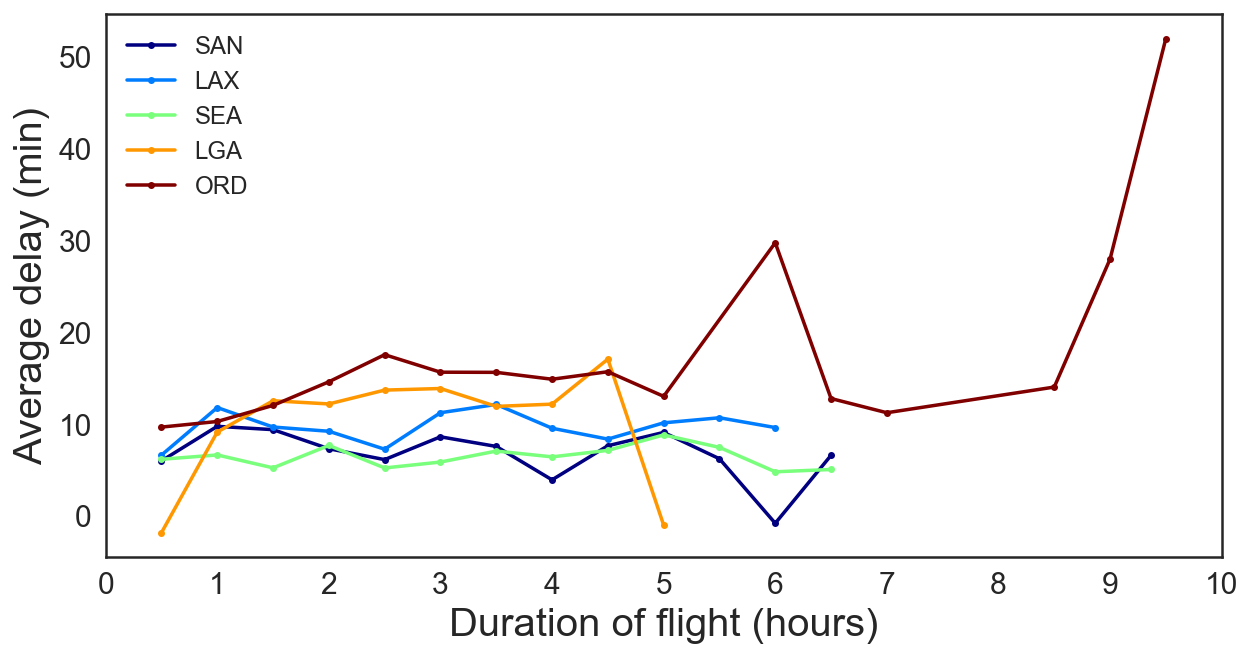

In [16]:
# Plot for many aps
aps = ['SAN','LAX','SEA','LGA','ORD']

def getcmaprgb(N, cmap):
	"""Get the RGB values of N colors across a colormap"""
	return cmap(np.linspace(0,255,N).astype(int))
from matplotlib import cm
colors = getcmaprgb(len(aps),cm.jet)

plt.figure(figsize=(10,5))
for i, ap in enumerate(aps):
    df_ap = mean_delays.loc[ap]
    hs = df_ap.index.values
    ds = df_ap['DEPARTURE_DELAY']['mean'].values
    plt.plot(hs/2, ds,'.-',color=colors[i],label=ap)
plt.xlabel('Duration of flight (hours)',size=20)
plt.ylabel('Average delay (min)', size=20)
plt.yticks(size=15)
plt.xticks(np.arange(11),size=15)
plt.legend(loc='best',fontsize=12)

# Departure hour for all flights

In [33]:
gb_aph = flights_df[['HALFHRS','DEPARTURE_DELAY']].groupby(['HALFHRS'])
mean_delays = gb_aph.agg(['mean','count','sem'])

In [34]:
mean_delays['DEPARTURE_DELAY']['sem'].values

array([ 0.06090487,  0.03196378,  0.03415614,  0.04038827,  0.0448762 ,
        0.0638587 ,  0.07475148,  0.08348955,  0.09818096,  0.10907403,
        0.12926889,  0.14982186,  0.25143777,  1.81303368,  1.7720071 ,
        1.58922345,  2.73229303,  2.946663  ,  1.83353386,  2.52480486,
        2.07081179,  6.66729088,  4.50096991])

/Users/scott/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


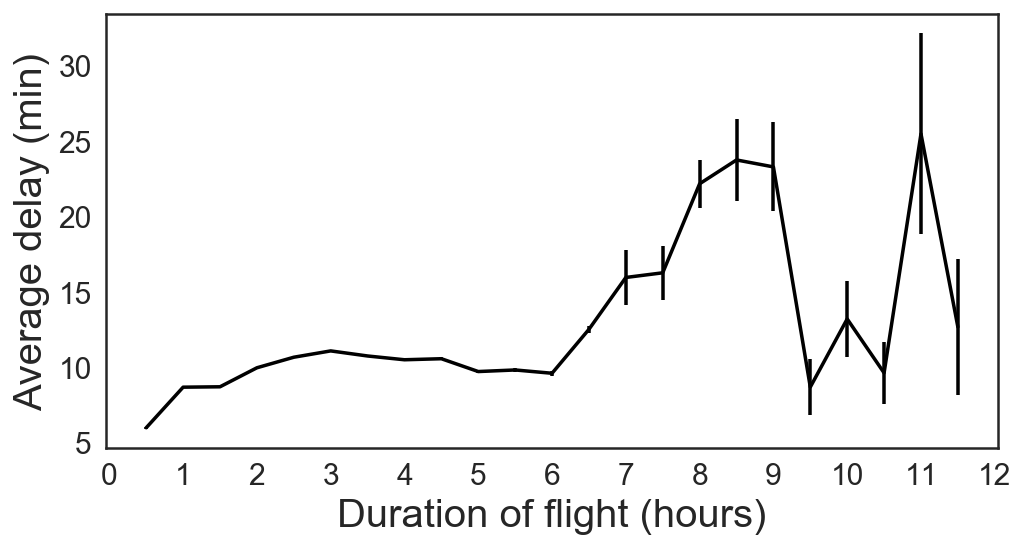

In [47]:
x = np.arange(len(hs))
hs = mean_delays.index.values
ds = mean_delays['DEPARTURE_DELAY']['mean'].values
plt.figure(figsize=(8,4))
plt.errorbar(hs/2, ds,yerr=mean_delays['DEPARTURE_DELAY']['sem'].values,color='k')
plt.xlabel('Duration of flight (hours)',size=20)
plt.ylabel('Average delay (min)', size=20)
plt.yticks(size=15)
plt.xticks(np.arange(13),size=15)
plt.legend(loc='best',fontsize=12)

(-0.12931960192810821, 0.54700678907655265)


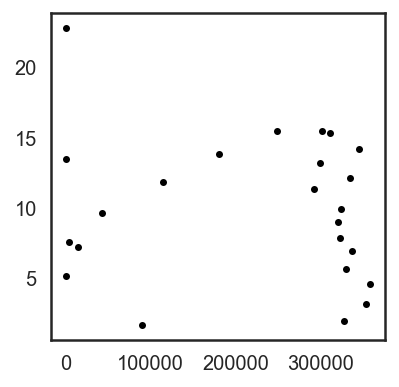

In [68]:
delay_means = mean_delays['DEPARTURE_DELAY']['mean'].values
flight_counts = mean_delays['DEPARTURE_DELAY']['count'].values
plt.figure(figsize=(3,3))
plt.plot(flight_counts,delay_means,'k.')
print(sp.stats.pearsonr(flight_counts,delay_means))